# Creating statistics and maps of street designations for communes

## Load libraries and data

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time
import pysal as ps
from legendgram import legendgram
import esda

%matplotlib inline

In [2]:
%%time 

# Street name designations
streetnames = pd.read_csv('../Datapreparation/streetnames.csv', encoding='UTF-8-SIG', sep=';')

# Specific street name designations
streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)

# Communes data
com = pd.read_csv('data/gmde_info.csv', encoding='UTF-8-SIG', sep=';')

# Communes geometries
com_geom = geopandas.read_file('data/gemeinden.geojson')

# Create dataset with all information on commune level
communes = pd.merge(com_geom, com, on=['GMDNR'], how='outer')

CPU times: total: 4.23 s
Wall time: 5.25 s


## Mapping most common generic street term per commune

In [265]:
#get most common generic street designation per commune
commune_top_term = streetnames_s.groupby(['COM_FOSNR'])['STR_TERMS'].agg(pd.Series.mode).to_frame()

In [266]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', "['strasse' 'weg']", '[]', 'chemin',
       'rue', 'route', "['gasse' 'weg']", "['impasse' 'route']",
       'impasse', "['chemin' 'rue']", "['chemin' 'route']", 'gasse',
       "['steg' 'strasse']", "['steg' 'weg']", 'allee', 'platz', 'voa',
       'voia', 'veia', 'via', 'vietta', 'strada', 'ruelle',
       "['chemin' 'route' 'rue']", "['route' 'rue']",
       "['route' 'ruelle']", "['chemin' 'gasse' 'route' 'rue' 'ruelle']"],
      dtype=object)

In [267]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term['STR_TERMS'] = commune_top_term['STR_TERMS'].str.replace("(' ').*","", regex=True)

In [268]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', 'nan', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'allee', 'platz', 'voa', 'voia', 'veia', 'via',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [269]:
streetnames_s['classif'] = streetnames_s['classif'].replace('Andere', np.NaN)

In [5]:
commune_top_term_s = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.mode).to_frame()

In [6]:
commune_top_term_s.classif.apply(lambda x: str(x)).unique()

array(['Andere', 'Natur', "['Andere' 'Natur']", 'Ortschaft', 'Siedlung',
       "['Andere' 'Gewässer' 'Lebewesen' 'Person' 'Religion' 'Siedlung']",
       'Lebewesen', "['Lebewesen' 'Siedlung']", "['Natur' 'Ortschaft']",
       "['Andere' 'Berg' 'Natur']", "['Andere' 'Person' 'Siedlung']",
       "['Lebewesen' 'Natur' 'Ortschaft']", "['Andere' 'Siedlung']",
       "['Natur' 'Siedlung']", 'Gewässer', "['Berg' 'Natur']",
       "['Andere' 'Lebewesen' 'Ortschaft' 'Siedlung']",
       "['Andere' 'Lebewesen']", "['Andere' 'Natur' 'Siedlung']", 'Berg',
       "['Andere' 'Ortschaft']", "['Andere' 'Person']",
       "['Berg' 'Ortschaft']", 'Person', "['Andere' 'Natur' 'Person']",
       "['Berg' 'Siedlung']", "['Person' 'Siedlung']",
       "['Lebewesen' 'Ortschaft']", "['Ortschaft' 'Siedlung']",
       "['Andere' 'Natur' 'Person' 'Siedlung']", "['Ortschaft' 'Person']",
       "['Andere' 'Natur' 'Ortschaft']"], dtype=object)

In [7]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term_s['classif'] = commune_top_term_s['classif'].str.replace("(' ').*","", regex=True)

In [8]:
commune_top_term_s.classif.apply(lambda x: str(x)).unique()

array(['Andere', 'Natur', 'nan', 'Ortschaft', 'Siedlung', 'Lebewesen',
       'Gewässer', 'Berg', 'Person'], dtype=object)

In [274]:
communes = pd.merge(communes, commune_top_term, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [9]:
communes = pd.merge(communes, commune_top_term_s, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [10]:
communes.columns

Index(['FID', 'GMDHISTID_x', 'GMDNR', 'GMDNAME_x', 'BZHISTID_x', 'BZNR_x',
       'KTNR_x', 'GRNR_x', 'AREA_HA_x', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX',
       'E_CNTR_x', 'N_CNTR_x', 'Z_MIN', 'Z_MAX', 'Z_AVG', 'Z_MED', 'Z_CNTR_x',
       'geometry', 'GMDHISTID_y', 'GMDNAME_y', 'BZHISTID_y', 'BZNR_y',
       'KTNR_y', 'GRNR_y', 'AREA_HA_y', 'E_CNTR_y', 'N_CNTR_y', 'Z_CNTR_y',
       'GMD_STR_LENGTH', 'classif'],
      dtype='object')

(2468003.35, 2851257.65, 1064234.8020000015, 1306970.712999999)

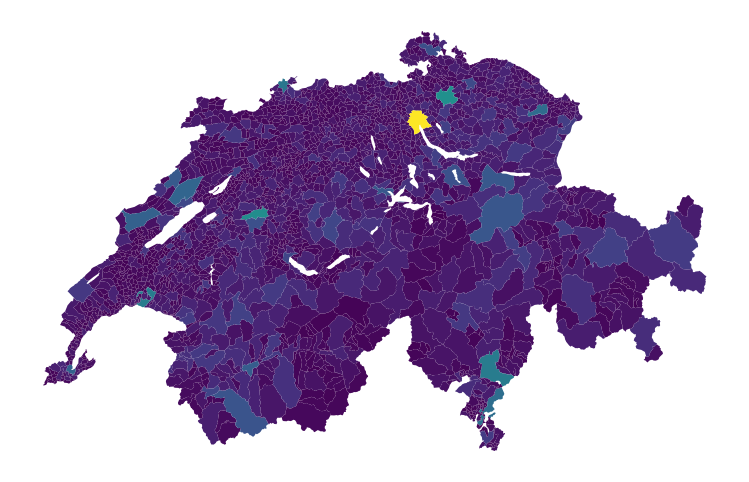

In [278]:
communes.plot(column='GMD_STR_LENGTH', figsize=(10, 6))
plt.axis('off')

In [279]:
communes['STR_TERMS'] = communes['STR_TERMS'].fillna('other')

In [280]:
communes['STR_TERMS'].apply(lambda x: str(x)).unique()

array(['strasse', 'via', 'weg', 'wäg', 'other', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'allee', 'platz', 'voa', 'voia', 'veia',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [284]:
colors = {
    'allee': '#01665e',
    'chemin': '#cab2d6',
    'gasse': '#1f78b4',
    'impasse': '#e31a1c',
    'platz': '#35978f',
    'route': '#fb9a99',
    'rue': '#b2df8a',
    'ruelle': '#33a02c',
    'strada': '#ffff33',
    'strasse': '#a6cee3',
    'veia': '#f1b6da',
    'via': '#fee08b',
    'vietta': '#762a83',
    'voa': '#c51b7d',
    'voia': '#8c510a',
    'wäg': '#ff7f00',
    'weg': '#fdbf6f',
    'other': '#d9d9d9',
}


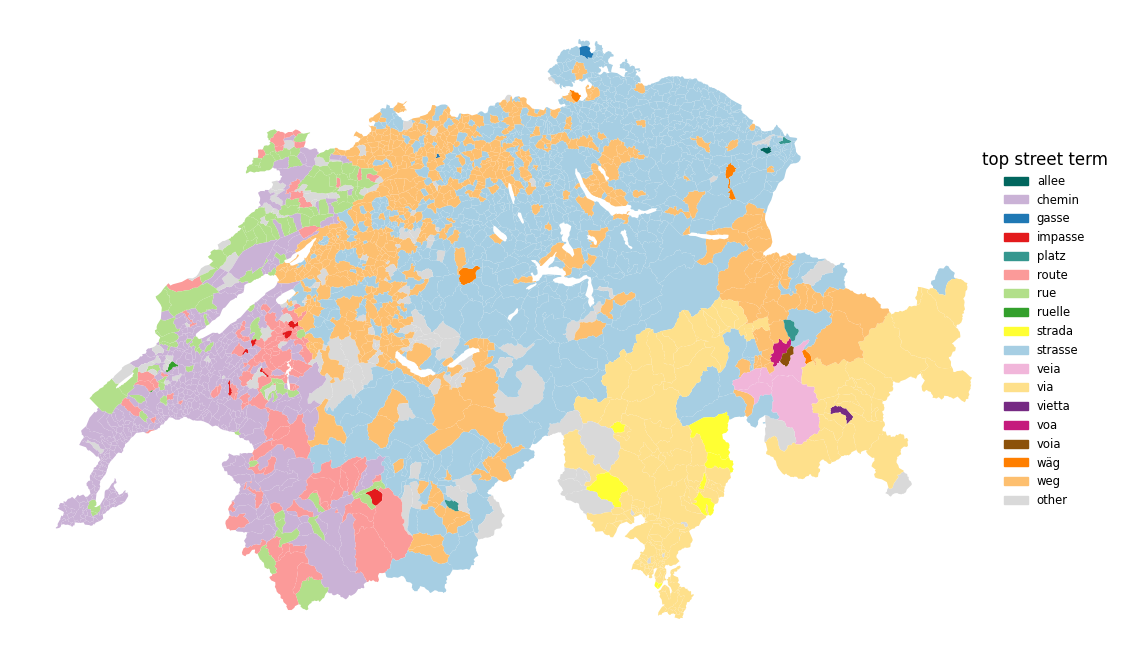

In [285]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes.plot(ax=ax, 
                        color=[colors[d] for d in communes.STR_TERMS])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top street term',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))

## Mapping ratio of named streets (vs streets without name)

In [288]:
# Street name geometries
streets_geom = geopandas.read_file('data/pure_line.geojson')

In [289]:
# Create dataset with all information on street level
streetnames_geom = pd.merge(streets_geom, streetnames, on=['STR_ESID','STR_ESID'], how='outer')

In [290]:
streetnames_length_comm = streetnames_geom.dissolve(by='COM_FOSNR', aggfunc={
         "LENGTH": "sum",
         "COM_NAME": "first",
         "COM_FOSNR": "first"    
     })

In [291]:
streetnames_length_comm.columns

Index(['geometry', 'LENGTH', 'COM_NAME', 'COM_FOSNR'], dtype='object')

In [292]:
# to remove ambiguity error
streetnames_length_comm.rename(columns = {'COM_FOSNR':'FOSNR'}, inplace = True)

In [293]:
#now we have per commune street length AND streetname length
communes_length = pd.merge(communes, streetnames_length_comm, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [294]:
communes_length.LENGTH = communes_length.LENGTH/1000

In [295]:
communes_length = communes_length.assign(ratioNamed = communes_length.LENGTH/communes_length.GMD_STR_LENGTH)

In [296]:
# to remove ambiguity error
communes_length.rename(columns = {'geometry_x':'geometry'}, inplace = True)

In [297]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].fillna('0')

In [298]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].astype(str).astype(float)

Text(0.5, 1.0, 'Verhältnis benannte vs. unbenannte Strassen')

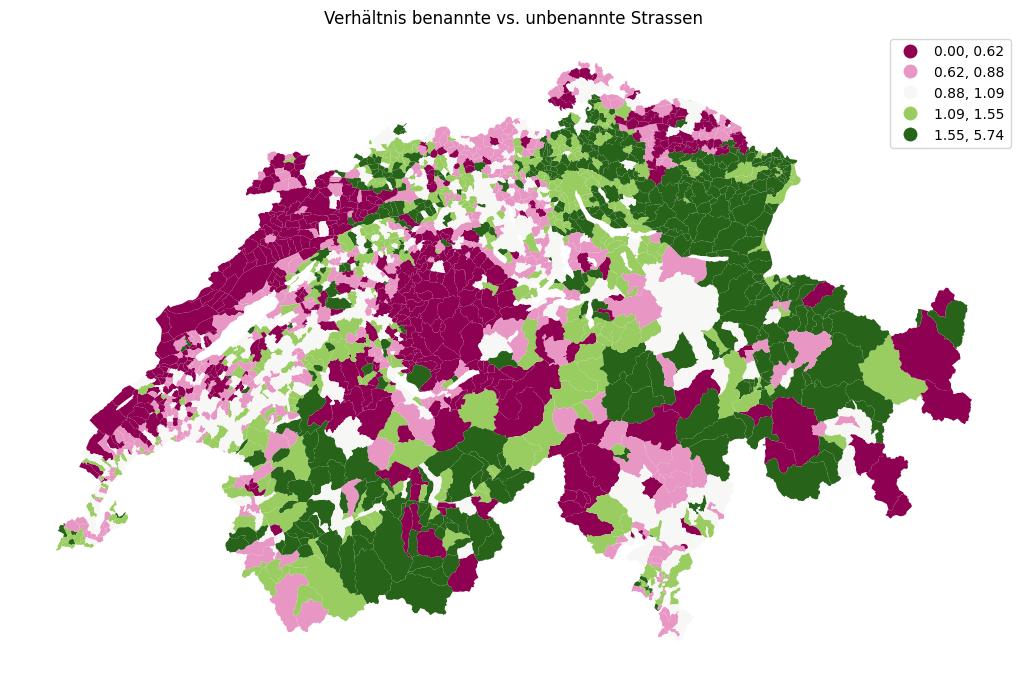

In [313]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes_length.plot(column='ratioNamed', 
                     cmap='PiYG', 
                     figsize=(10, 6), 
                     ax=ax, 
                     legend=True,
                     scheme='quantiles')

plt.axis('off')
plt.title("Verhältnis benannte vs. unbenannte Strassen")

# Mapping most common specific street term per commune

In [11]:
communes['classif'] = communes['classif'].fillna('no_value')

In [12]:
communes['classif'].apply(lambda x: str(x)).unique()

array(['Andere', 'Natur', 'no_value', 'Ortschaft', 'Siedlung',
       'Lebewesen', 'Gewässer', 'Berg', 'Person'], dtype=object)

In [13]:
colors = {
    'Ortschaft': '#e41a1c',
    'Natur': '#4daf4a',
    'Gewässer': '#1f78b4',
    'Lebewesen': '#984ea3',
    'Siedlung': '#ff7f00',
    'Person': '#ffff33',
    'Berg': '#a65628',
    'Religion': '#f781bf',
    #'Andere' : '#fee08b',
    'no_value': '#d9d9d9',
}

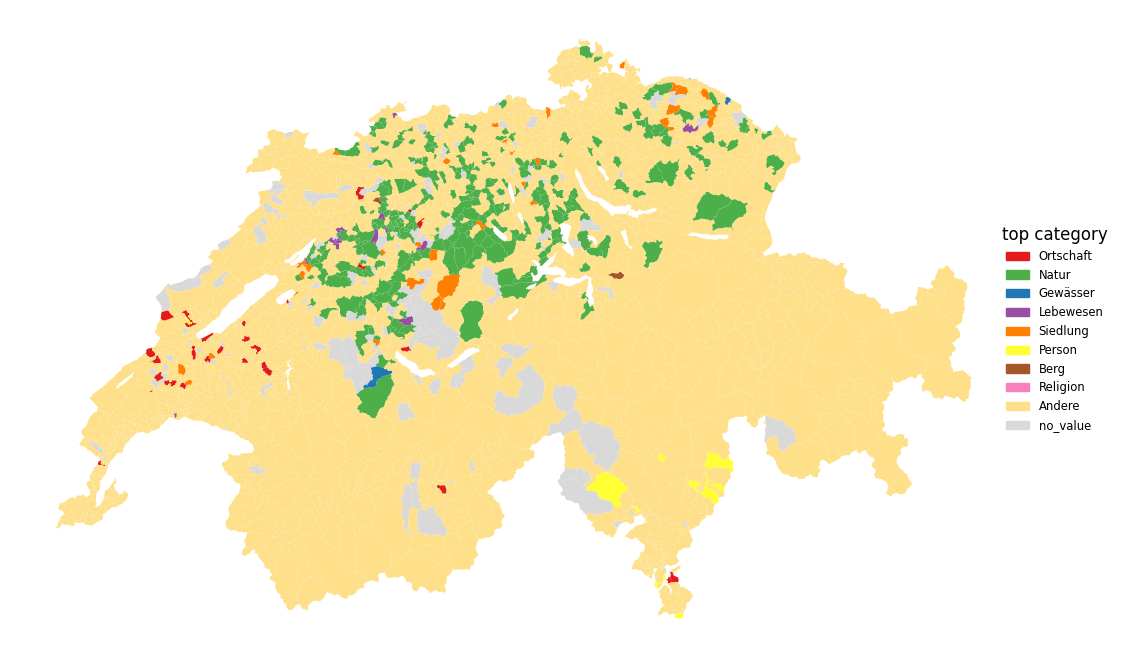

In [14]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes.plot(ax=ax, 
                        color=[colors[d] for d in communes.classif])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top category',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))

## Mapping percent of common specific street term per commune

In [15]:
streetnames_s.groupby(['COM_FOSNR', 'classif']).size().to_frame()

0
COM_FOSNR classif      
1.0       Andere     30
          Berg        7
          Gewässer    3
          Lebewesen   1
          Natur      15
...                  ..
6810.0    Lebewesen   2
          Ortschaft  16
          Person      4
          Religion    1
          Siedlung   11

[15991 rows x 1 columns]

In [16]:
kategorie = 'Person'

subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

In [17]:
alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

In [18]:
kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

In [19]:
kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)
kategorie_merge

,classif_x,classif_y,percent_subset
COM_FOSNR,,,
1.0,2,75,2.666667
2.0,5,197,2.538071
3.0,9,139,6.474820
4.0,8,157,5.095541
5.0,6,178,3.370787
...,...,...,...
6806.0,4,27,14.814815
6807.0,6,53,11.320755
6808.0,11,60,18.333333


In [20]:
communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

In [21]:
import mapclassify as mc
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=9).bins
bins

array([ 0.        ,  1.63934426,  2.93300654,  4.16666667,  5.47138047,
        7.05128205,  9.55077006, 14.28571429, 50.        ])

Text(0.5, 0, '% Kategorie: Person')

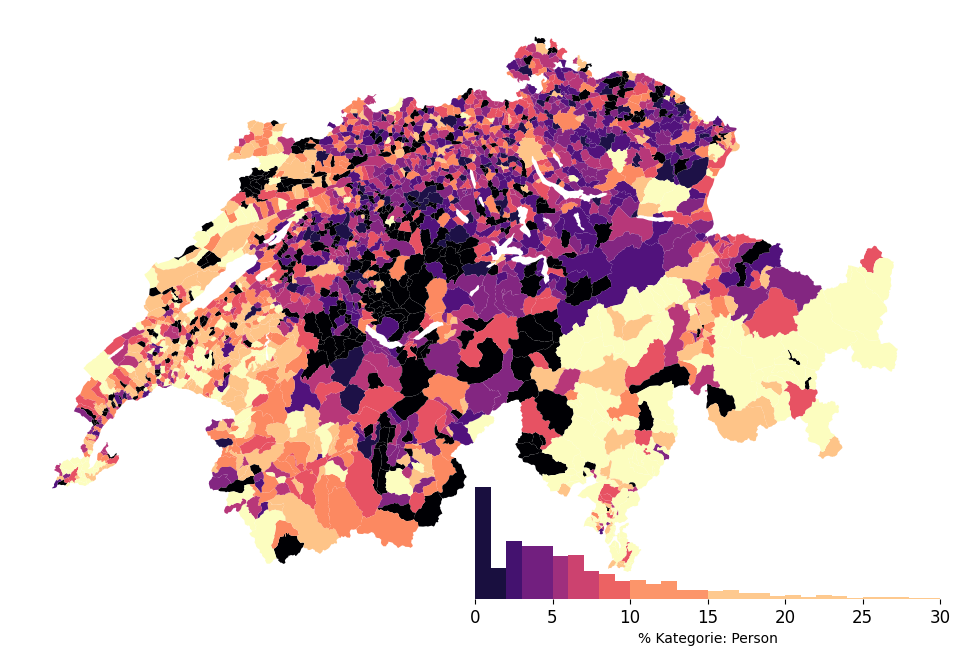

In [22]:
import palettable.matplotlib as palmpl
import mapclassify as mc

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=9, ax=ax, cmap='magma', scheme='Quantiles')

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=9).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Magma_9,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )


xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

Text(0.5, 0, '% Kategorie: Person')

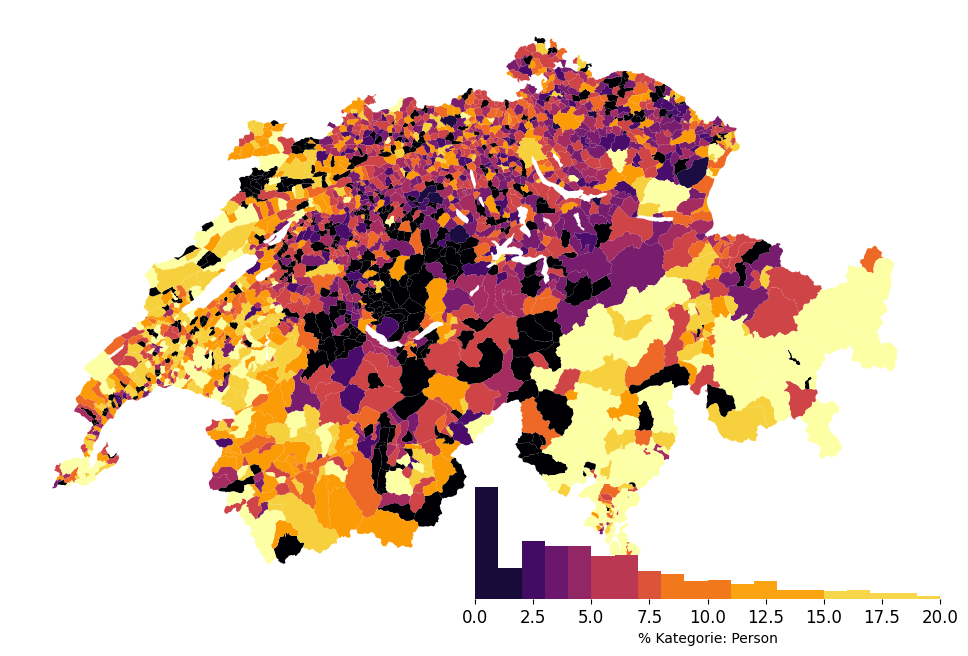

In [33]:
kategorie = 'Person'

subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,20) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

In [29]:
communes_kategorie

,FID,GMDHISTID_x,GMDNR,GMDNAME_x,BZHISTID_x,BZNR_x,KTNR_x,GRNR_x,AREA_HA_x,E_MIN,...,GRNR_y,AREA_HA_y,E_CNTR_y,N_CNTR_y,Z_CNTR_y,GMD_STR_LENGTH,classif,classif_x,classif_y,percent_subset
0,0,16620,3112,Schwende-Rüte,10252,1600,16,5,9833,2742569,...,5,9833,2750500,1243000,799,108.036588,Andere,51.0,106.0,48.113208
1,1,16619,5240,Val Mara,10003,2105,21,7,1115,2718331,...,7,1115,2720100,1086500,290,27.591132,Andere,37.0,77.0,48.051948
2,2,13256,1,Aeugst am Albis,10053,101,1,4,791,2678111,...,4,791,2679300,1235700,700,26.516156,Andere,30.0,75.0,40.000000
3,3,11742,2,Affoltern am Albis,10053,101,1,4,1059,2673826,...,4,1059,2676800,1236800,490,66.711839,Natur,55.0,197.0,27.918782
4,4,11801,3,Bonstetten,10053,101,1,4,743,2675745,...,4,743,2677800,1241000,544,31.501571,Andere,51.0,139.0,36.690647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,2143,13353,6806,Vendlincourt,10226,2603,26,2,915,2575722,...,2,915,2578200,1255600,441,19.431732,Andere,10.0,27.0,37.037037
2144,2144,14970,6807,Basse-Allaine,10226,2603,26,2,2304,2566914,...,2,2304,2569300,1258900,385,46.657442,Andere,20.0,53.0,37.735849
2145,2145,14965,6808,Clos du Doubs,10226,2603,26,2,6175,2569448,...,2,6175,2579100,1246300,449,101.283739,Andere,26.0,60.0,43.333333
2146,2146,16120,6809,Haute-Ajoie,10226,2603,26,2,4093,2557722,...,2,4093,2567000,1249100,492,64.072282,Andere,34.0,62.0,54.838710


Text(0.5, 0, '% Strassenname einer Kategorie zugeordnet')

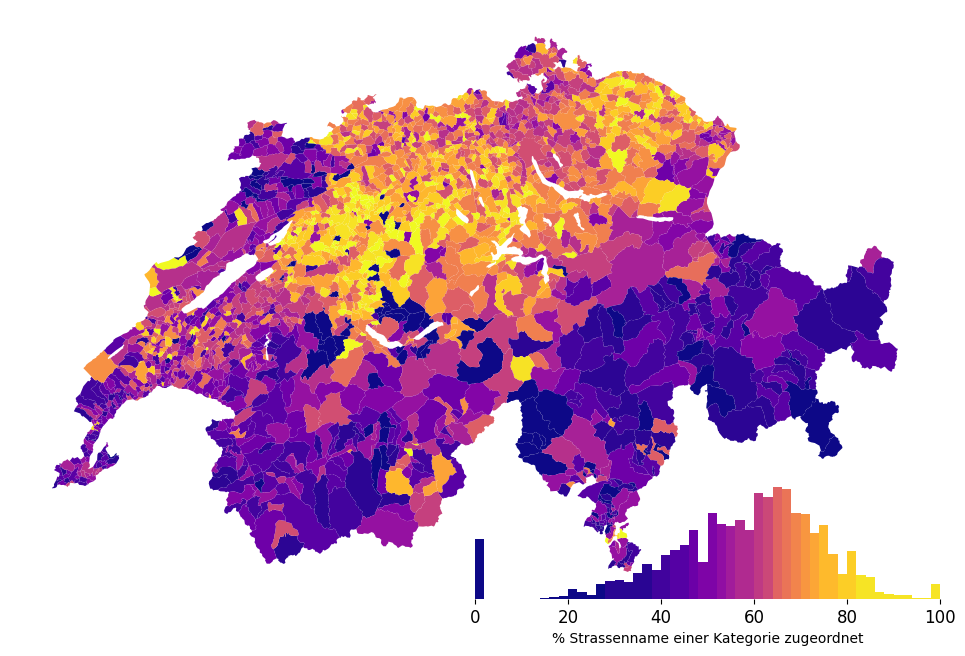

In [46]:
kategorie = 'Andere'

subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = 100 - (kategorie_merge.classif_x/kategorie_merge.classif_y*100))

communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

import palettable.matplotlib as palmpl
import mapclassify as mc

k=20
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='plasma', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Plasma_20,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,100) # clip the displayed range of the histogram
           )

xlabel = '% Strassenname einer Kategorie zugeordnet' 
plt.xlabel(xlabel)

https://pysal.org/scipy2019-intermediate-gds/stochastic/gds5-exploration.html

https://pysal.org/scipy2019-intermediate-gds/stochastic/gds6-spatial-clusters.html

These types of local spatial autocorrelation describe similarities or dissimilarities between a specific 
polygon with its neighboring polygons. The upper left quadrant for example indicates that polygons with low 
values are surrounded by polygons with high values (LH). The lower right quadrant shows polygons with high 
values surrounded by neighbors with low values (HL). This indicates an association of dissimilar values.

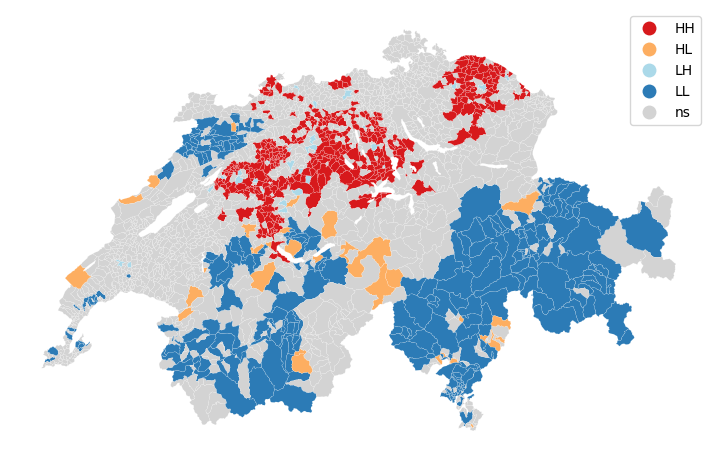

In [47]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local

gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
plt.show()